CWD = /Users/dwiprabowo/Documents/SCNU/Road to Thesis/SLR FINAL BISMILLAH
Output dir = /Users/dwiprabowo/Downloads/greencompactcityurban/25/_outputs
Loaded (full text, no References): How can urban blue-green space be planned for climate adaption in high-latitude cities? A seasonal perspective.pdf
Loaded (full text, no References): Hyperlocal mapping of urban air temperature using remote sensing and crowdsourced weather data.pdf
Loaded (full text, no References): Terrain-sensitive carbon management for SDG11- A spatial-explicit assessment of mountainous cities under climate and urbanization pressures.pdf
Loaded (full text, no References): Urban Form Compaction and Energy Use Intensity in New Social Housing Neighborhoods in the UAE.pdf
Loaded (full text, no References): Greening metropolitan growth  integrating nature recreation  compactness and spaciousness in regional development planning.pdf
Loaded (full text, no References): Spatiotemporal Heterogeneity and Socioeconomic Drivers of 

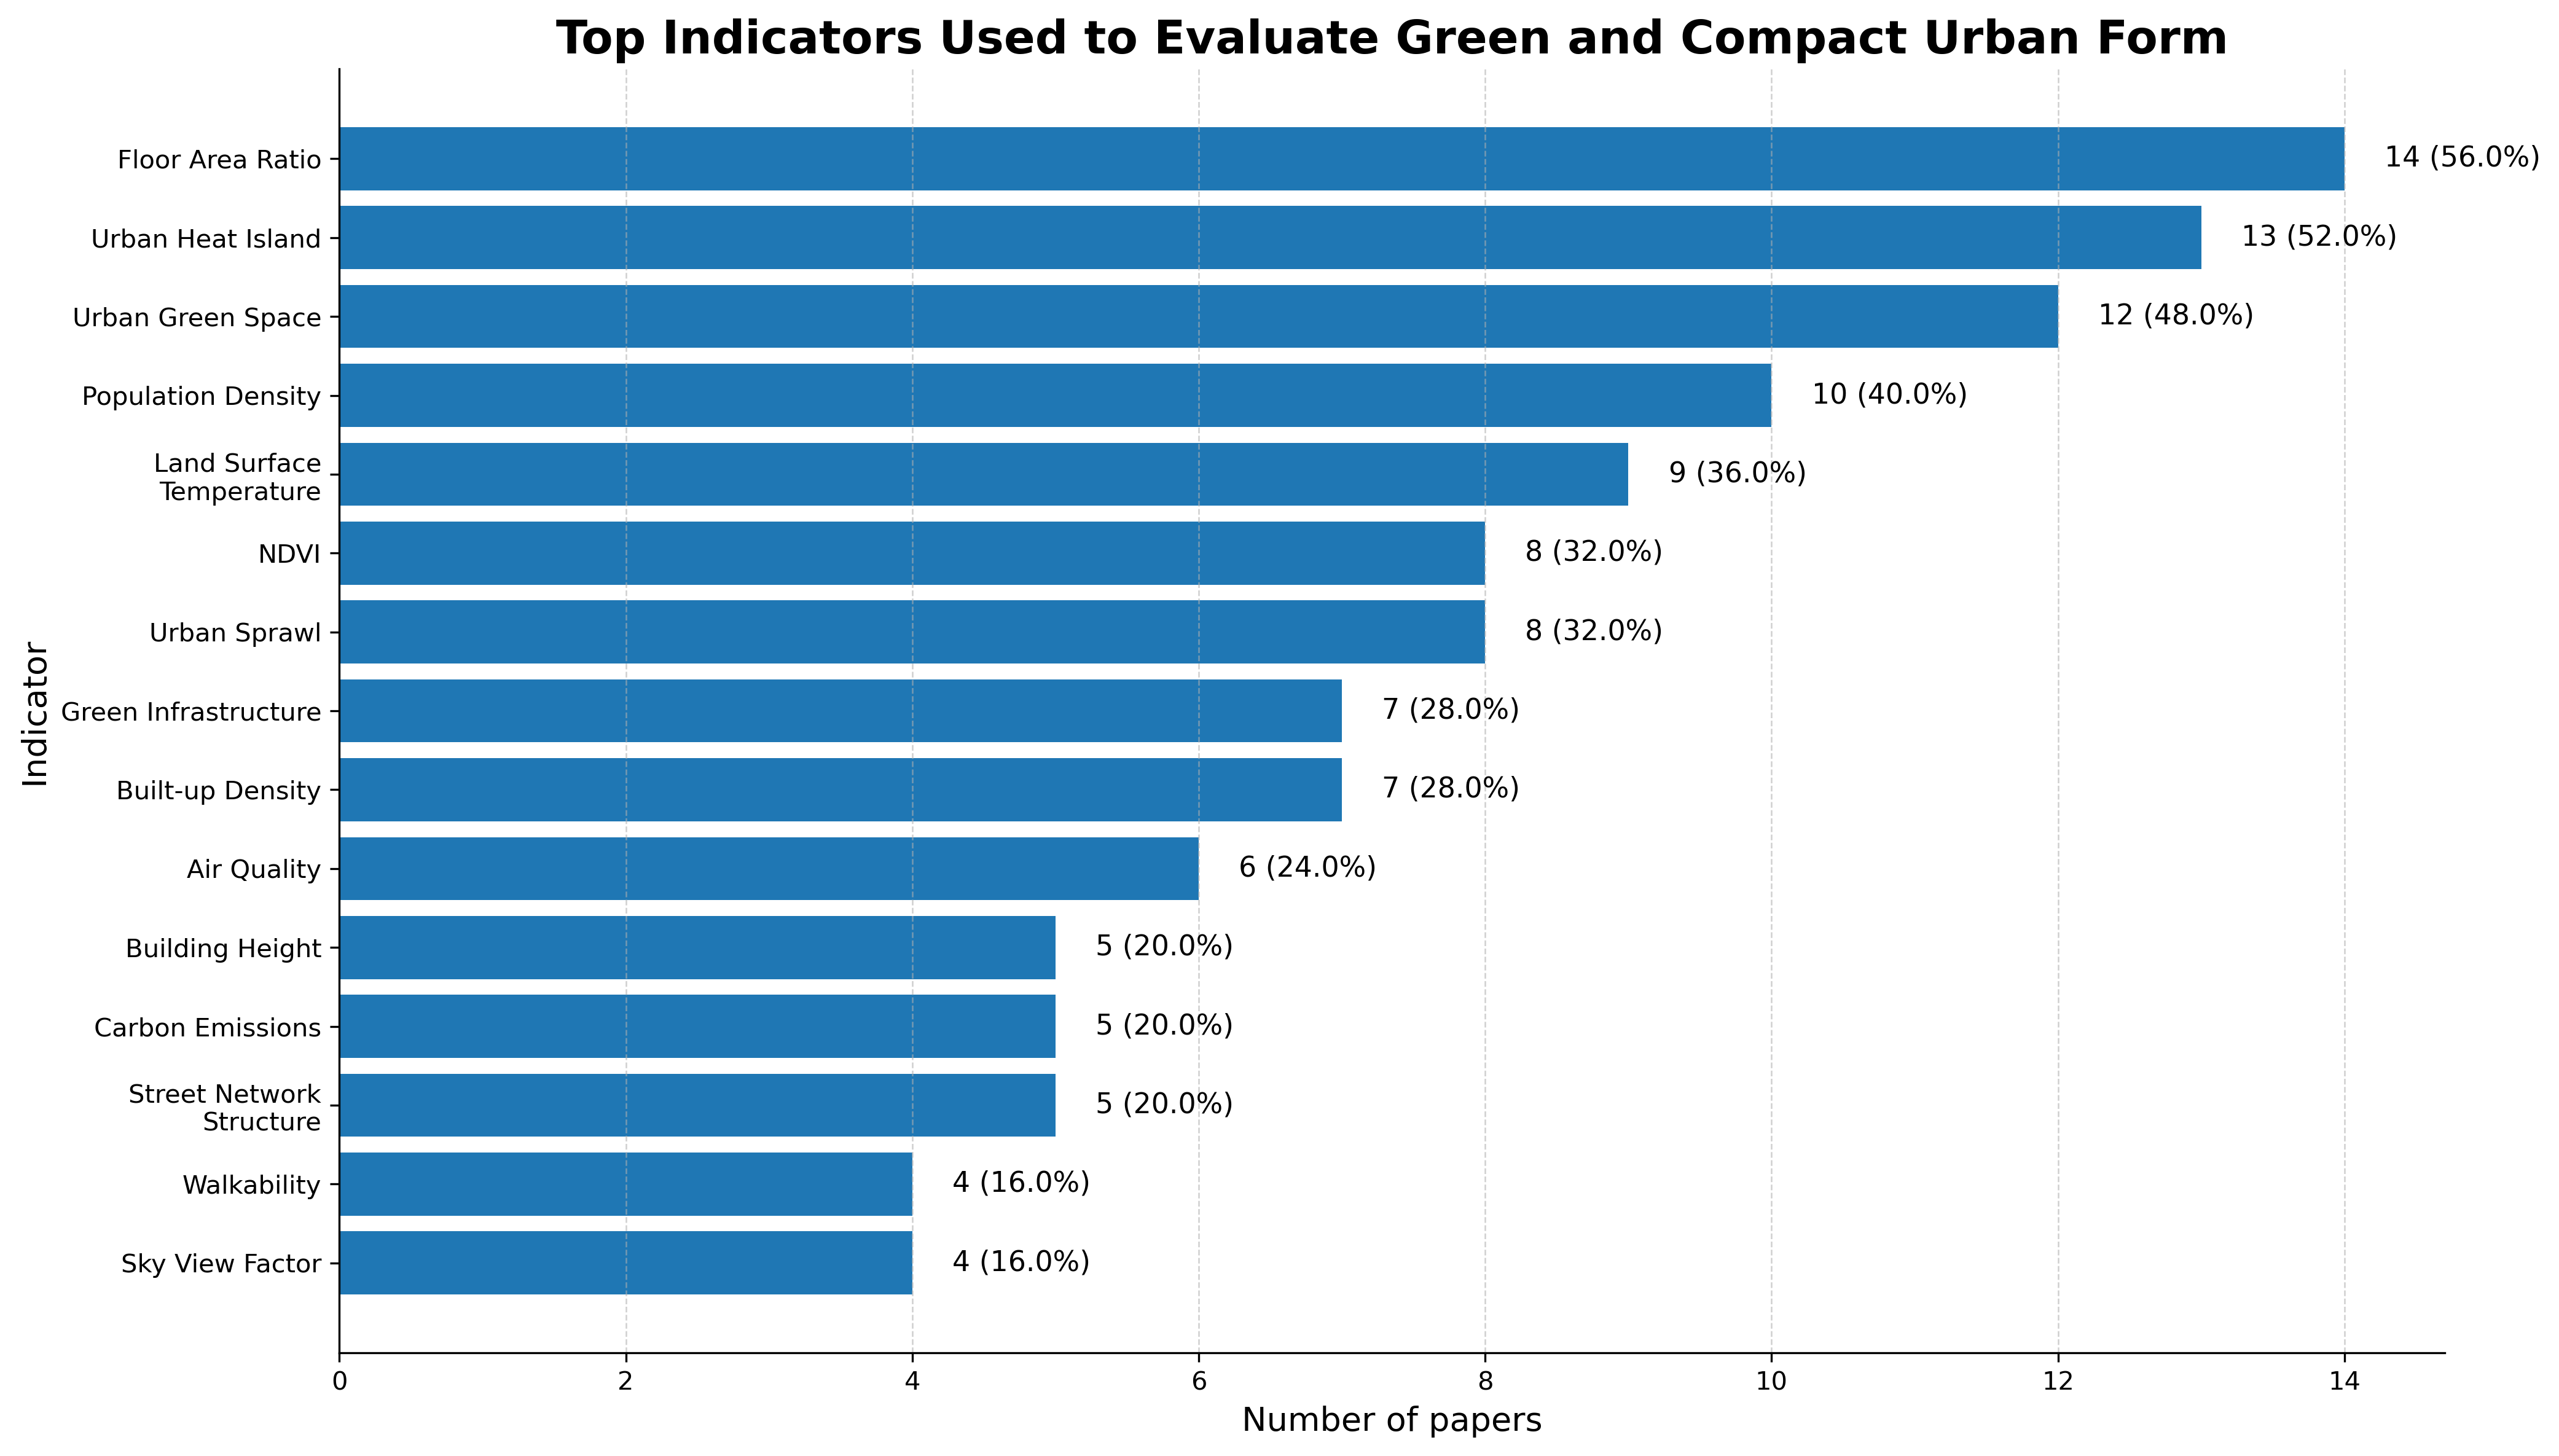


Initial network: 19 nodes | 89 edges
Subgraph: 19 nodes | 89 edges
Saved figure → /Users/dwiprabowo/Downloads/greencompactcityurban/25/_outputs/indicator_network_Q1_final_300dpi.png


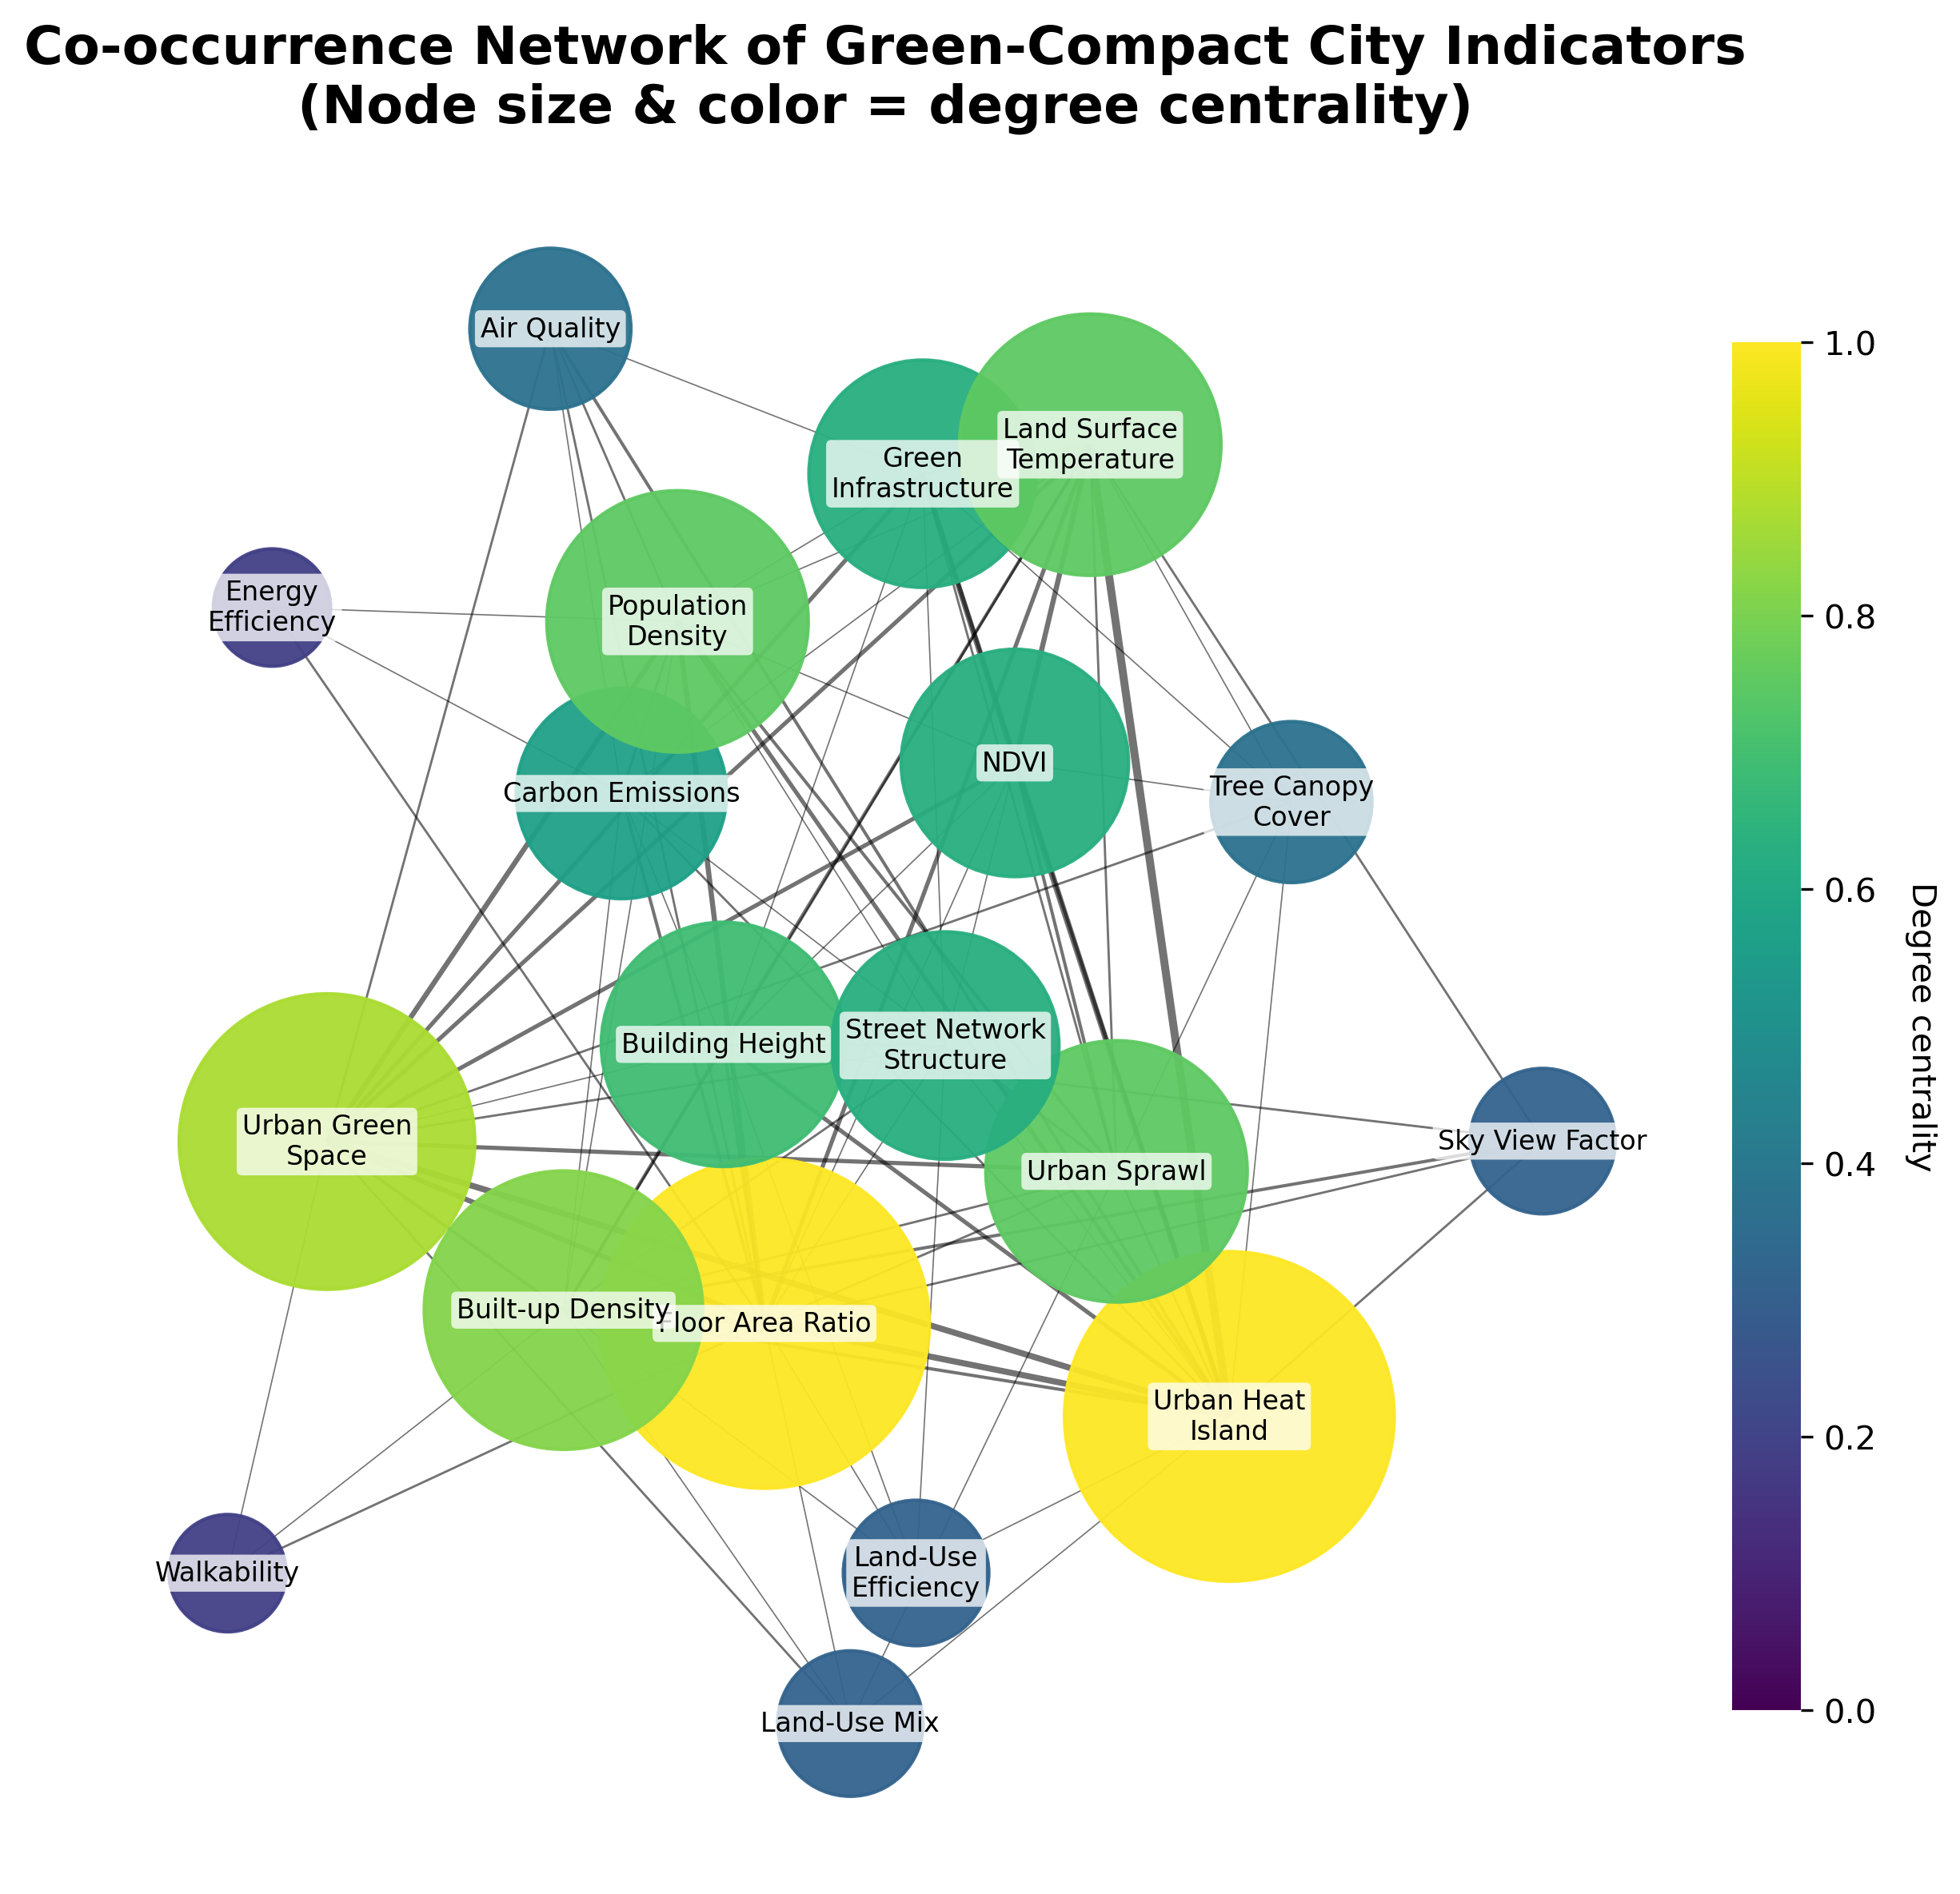


--- Top 10 Indicators by Degree Centrality ---
Urban Heat Island                   : 0.889
Floor Area Ratio                    : 0.889
Urban Green Space                   : 0.778
Built-up Density                    : 0.722
Land Surface Temperature            : 0.667
Population Density                  : 0.667
Urban Sprawl                        : 0.667
Building Height                     : 0.611
Green Infrastructure                : 0.556
NDVI                                : 0.556


In [6]:
import os
import re
import textwrap
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
import fitz  # PyMuPDF
import pandas as pd  


# ==========================================================
# A) INDICATOR ONTOLOGY + KEYWORD DICTIONARY (Table A2)
# ==========================================================

INDICATORS = {
    # (1) Morphology–Density
    "MOR_DEN": {"canonical": "Population Density", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["population density", "inhabitants per hectare"]},
    "MOR_FAR": {"canonical": "Floor Area Ratio", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["floor area ratio", "FAR", "plot ratio", "FSI"]},
    "MOR_BU": {"canonical": "Built-up Density", "dimension": "Morphology–Density", "ontology": "Metric",
               "keywords": ["built-up density", "building density"]},
    "MOR_HGT": {"canonical": "Building Height", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["building height", "building storeys", "number of storeys"]},
    "MOR_COV": {"canonical": "Site Coverage", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["site coverage", "building coverage ratio"]},
    "MOR_BLK": {"canonical": "Block Size", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["block size", "urban block dimension"]},
    "MOR_NET": {"canonical": "Street Network Structure", "dimension": "Morphology–Density", "ontology": "Component",
                "keywords": ["street network", "road network"]},
    "MOR_SVF": {"canonical": "Sky View Factor", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["sky view factor", "SVF"]},
    "MOR_SPL": {"canonical": "Urban Sprawl", "dimension": "Morphology–Density", "ontology": "Metric",
                "keywords": ["urban sprawl", "suburban sprawl"]},

    # (2) Mobility–Accessibility
    "MOB_WLK": {"canonical": "Walkability", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["walkability", "walk score"]},
    "MOB_BIK": {"canonical": "Bicycle Accessibility", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["bike accessibility", "cyclability"]},
    "MOB_PUB": {"canonical": "Public Transport Accessibility", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["public transit access", "transit accessibility"]},
    "MOB_CON": {"canonical": "Street Connectivity", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["street connectivity", "intersection density"]},
    "MOB_CTH": {"canonical": "Pedestrian Catchment Area", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["pedestrian catchment area", "pedestrian shed"]},
    "MOB_MOD": {"canonical": "Modal Split", "dimension": "Mobility–Accessibility", "ontology": "Metric",
                "keywords": ["modal split", "mode share"]},
    "MOB_TOD": {"canonical": "Transit-Oriented Development", "dimension": "Mobility–Accessibility", "ontology": "System",
                "keywords": ["transit-oriented development", "TOD"]},

    # (3) Land-Use Mix & Functional Diversity
    "LUM_MIX": {"canonical": "Land-Use Mix", "dimension": "Land-Use Mix & Functional Diversity", "ontology": "Metric",
                "keywords": ["land-use mix", "mixed land use"]},
    "LUM_ENT": {"canonical": "Entropy Index", "dimension": "Land-Use Mix & Functional Diversity", "ontology": "Metric",
                "keywords": ["entropy index", "land-use entropy"]},
    "LUM_JOB": {"canonical": "Jobs–Housing Balance", "dimension": "Land-Use Mix & Functional Diversity", "ontology": "Metric",
                "keywords": ["jobs–housing balance", "jobs-housing balance"]},
    "LUM_EFF": {"canonical": "Land-Use Efficiency", "dimension": "Land-Use Mix & Functional Diversity", "ontology": "Metric",
                "keywords": ["land-use efficiency", "land use efficiency"]},

    # (4) Green & Blue Infrastructure
    "GBI_SYS": {"canonical": "Green Infrastructure", "dimension": "Green & Blue Infrastructure", "ontology": "System",
                "keywords": ["green infrastructure", "green-blue infrastructure"]},
    "GBI_UGS": {"canonical": "Urban Green Space", "dimension": "Green & Blue Infrastructure", "ontology": "Component",
                "keywords": ["urban green space", "urban parks", "urban greenery"]},
    "GBI_CAN": {"canonical": "Tree Canopy Cover", "dimension": "Green & Blue Infrastructure", "ontology": "Metric",
                "keywords": ["tree canopy cover", "tree cover"]},
    "GBI_NDV": {"canonical": "NDVI", "dimension": "Green & Blue Infrastructure", "ontology": "Metric",
                "keywords": ["NDVI", "normalized difference vegetation index"]},
    "GBI_ACC": {"canonical": "Park Accessibility", "dimension": "Green & Blue Infrastructure", "ontology": "Metric",
                "keywords": ["park accessibility", "access to parks"]},
    "GBI_PER": {"canonical": "Permeable Surface Ratio", "dimension": "Green & Blue Infrastructure", "ontology": "Metric",
                "keywords": ["permeable surface ratio"]},
    "GBI_SUD": {"canonical": "Sustainable Urban Drainage Systems", "dimension": "Green & Blue Infrastructure", "ontology": "System",
                "keywords": ["SUDS", "sustainable urban drainage", "LID"]},

    # (5) Climate & Environmental Performance
    "CLM_UHI": {"canonical": "Urban Heat Island", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["urban heat island", "UHI", "SUHI"]},
    "CLM_LST": {"canonical": "Land Surface Temperature", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["land surface temperature", "LST"]},
    "CLM_AIR": {"canonical": "Air Quality", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["air quality", "PM2.5", "NO2", "NO₂"]},
    "CLM_ENG": {"canonical": "Energy Efficiency", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["energy efficiency", "energy use intensity"]},
    "CLM_CAR": {"canonical": "Carbon Emissions", "dimension": "Climate & Environmental Performance", "ontology": "Outcome Metric",
                "keywords": ["carbon emissions", "CO2 emissions", "CO₂ emissions"]},
}


# ==========================================================
# B) TEXT NORMALIZATION
# ==========================================================
def normalize_text(s: str) -> str:
    if not s:
        return ""
    s = s.lower()
    s = (s.replace("no₂", "no2")
           .replace("co₂", "co2")
           .replace("pm₂.₅", "pm2.5")
           .replace("–", "-")
           .replace("—", "-"))
    s = re.sub(r"\s+", " ", s).strip()
    return s


# ==========================================================
# C) STRIP REFERENCES
# ==========================================================
def strip_references(full_text: str) -> str:
    text_lower = normalize_text(full_text)
    patterns = [
        r"\breferences\b",
        r"\bbibliography\b",
        r"\bworks cited\b",
        r"\breferences and notes\b",
        r"\bdaftar pustaka\b",
        r"\brujukan\b",
        r"참고문헌",
    ]
    cut_pos = None
    for pat in patterns:
        m = re.search(pat, text_lower)
        if m:
            cut_pos = m.start()
            break
    return full_text[:cut_pos] if cut_pos is not None else full_text


# ==========================================================
# D) COMPILE REGEX PATTERNS (safer matching)
# ==========================================================
def _kw_to_regex(kw: str) -> str:
    kw_norm = normalize_text(kw)
    escaped = re.escape(kw_norm)
    if re.fullmatch(r"[a-z0-9 \-]+", kw_norm):
        return r"\b" + escaped + r"\b"
    return escaped


def compile_indicator_patterns(indicators=INDICATORS):
    compiled = {}
    for code, meta in indicators.items():
        pats = [_kw_to_regex(k) for k in meta["keywords"]]
        big_pat = "(" + "|".join(pats) + ")"
        compiled[code] = re.compile(big_pat, flags=re.IGNORECASE)
    return compiled


INDICATOR_PATTERNS = compile_indicator_patterns()


# ==========================================================
# E) EXTRACT INDICATORS
# ==========================================================
def extract_indicators_from_text(text: str):
    t = normalize_text(text)
    found = set()
    for code, rx in INDICATOR_PATTERNS.items():
        if rx.search(t):
            found.add(code)
    return found


def build_indicator_sets_from_articles(articles_dict):
    out = {}
    for pid, text in articles_dict.items():
        codes = extract_indicators_from_text(text)
        if codes:
            out[pid] = codes
    return out


# ==========================================================
# F) LOAD PDFS
# ==========================================================
def load_pdfs_no_references(folder_path: str):
    articles = {}
    for fname in os.listdir(folder_path):
        if not fname.lower().endswith(".pdf"):
            continue

        pdf_path = os.path.join(folder_path, fname)
        doc = fitz.open(pdf_path)
        pages_text = [page.get_text("text") for page in doc]
        doc.close()

        full_text = "\n".join(pages_text)
        full_text_no_ref = strip_references(full_text)

        paper_id = os.path.splitext(fname)[0]
        articles[paper_id] = full_text_no_ref
        print(f"Loaded (full text, no References): {fname}")

    return articles


# ==========================================================
# ADDED: EXPORT RQ1 FREQUENCY CSV
# ==========================================================
def export_rq1_frequency_csv(co_data, out_csv_path):
    total_papers = len(co_data)
    counts = {}

    for codes in co_data.values():
        for c in codes:
            counts[c] = counts.get(c, 0) + 1

    df = pd.DataFrame({
        "Code": list(counts.keys()),
        "Indicator": [INDICATORS.get(c, {}).get("canonical", c) for c in counts.keys()],
        "Dimension": [INDICATORS.get(c, {}).get("dimension", "NA") for c in counts.keys()],
        "DocFreq_n": list(counts.values()),
        "FreqShare": [v / total_papers if total_papers else 0 for v in counts.values()],
        "TotalDocs": total_papers
    }).sort_values("DocFreq_n", ascending=False)

    # Ensure output dir exists
    out_dir = os.path.dirname(out_csv_path)
    if out_dir:
        os.makedirs(out_dir, exist_ok=True)

    df.to_csv(out_csv_path, index=False)
    print("Saved rq1_frequency.csv →", os.path.abspath(out_csv_path))
    return df


# ==========================================================
# G) FREQUENCY ANALYSIS (RQ1) - BAR CHART
# ==========================================================
def analyze_indicator_frequency(co_data, top_n=15, save_path="top_indicators_frequency_300dpi.png"):
    total_papers = len(co_data)
    counts = {}

    for codes in co_data.values():
        for c in codes:
            counts[c] = counts.get(c, 0) + 1

    sorted_codes = sorted(counts.items(), key=lambda x: x[1], reverse=True)

    print("\n" + "=" * 80)
    print("RQ1: Key indicators commonly used to evaluate green & compact urban form")
    print("=" * 80)
    print(f"\nAnalysis based on {total_papers} processed papers.\n")
    print(f"--- Top {top_n} Most Frequently Mentioned Indicators ---")

    for code, cnt in sorted_codes[:top_n]:
        meta = INDICATORS.get(code, {})
        cname = meta.get("canonical", code)
        dim = meta.get("dimension", "NA")
        print(f"{cname:<35} | {dim:<35} : {cnt:>3} ({(cnt/total_papers)*100:>5.1f}%)")

    top = sorted_codes[:top_n]
    names = [INDICATORS[c]["canonical"] for c, _ in top]
    vals = [cnt for _, cnt in top]
    pcts = [cnt / total_papers * 100 for _, cnt in top]

    wrapped_labels = ["\n".join(textwrap.wrap(nm, width=22)) for nm in names]

    fig, ax = plt.subplots(figsize=(14, 8), dpi=300)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    bars = ax.barh(wrapped_labels, vals)
    ax.invert_yaxis()

    ax.set_xlabel("Number of papers", fontsize=13)
    ax.set_ylabel("Indicator", fontsize=13)
    ax.set_title("Top Indicators Used to Evaluate Green and Compact Urban Form",
                 fontsize=18, fontweight="bold")

    ax.xaxis.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
    ax.yaxis.grid(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    max_count = max(vals) if vals else 1
    for bar, cnt, pct in zip(bars, vals, pcts):
        ax.text(bar.get_width() + 0.02 * max_count,
                bar.get_y() + bar.get_height() / 2,
                f"{cnt} ({pct:.1f}%)",
                va="center", ha="left", fontsize=11)

    plt.tight_layout()

    # ensure dir exists for figure
    fig_dir = os.path.dirname(save_path)
    if fig_dir:
        os.makedirs(fig_dir, exist_ok=True)

    plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
    print("Saved figure →", os.path.abspath(save_path))
    plt.show()

    return sorted_codes


# ==========================================================
# H) CO-OCCURRENCE NETWORK (RQ1)
# ==========================================================
def build_and_plot_network(co_data, min_edge_weight=2, max_nodes=35, save_path="indicator_network_Q1_final_300dpi.png"):
    G = nx.Graph()
    edge_w = {}

    for codes in co_data.values():
        codes = sorted(list(codes))
        for a, b in combinations(codes, 2):
            edge_w[(a, b)] = edge_w.get((a, b), 0) + 1

    for (a, b), w in edge_w.items():
        if w >= min_edge_weight:
            G.add_edge(a, b, weight=w)

    if G.number_of_nodes() == 0:
        print("No edges remain after threshold. Reduce min_edge_weight.")
        return None

    print(f"\nInitial network: {G.number_of_nodes()} nodes | {G.number_of_edges()} edges")

    dc = nx.degree_centrality(G)
    sorted_nodes = sorted(dc.items(), key=lambda x: x[1], reverse=True)

    top_nodes = [n for n, _ in sorted_nodes[:max_nodes]]
    H = G.subgraph(top_nodes).copy()
    print(f"Subgraph: {H.number_of_nodes()} nodes | {H.number_of_edges()} edges")

    dc_sub = nx.degree_centrality(H)
    max_c = max(dc_sub.values()) if dc_sub else 1.0
    norm = {n: dc_sub[n] / max_c for n in H.nodes()}

    pos = nx.kamada_kawai_layout(H, weight="weight")

    node_colors = [norm[n] for n in H.nodes()]
    node_sizes = [800 + (norm[n] ** 1.8) * 9000 for n in H.nodes()]

    weights = [H[u][v]["weight"] for u, v in H.edges()]
    if weights:
        w_min, w_max = min(weights), max(weights)
        edge_widths = [0.8 if w_min == w_max else 0.4 + 2.0 * (w - w_min) / (w_max - w_min) for w in weights]
    else:
        edge_widths = []

    labels = {n: "\n".join(textwrap.wrap(INDICATORS[n]["canonical"], width=16)) for n in H.nodes()}

    fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")

    nx.draw_networkx_edges(H, pos, width=edge_widths, alpha=0.55)
    nx.draw_networkx_nodes(H, pos,
                           node_size=node_sizes,
                           node_color=node_colors,
                           cmap=plt.cm.viridis,
                           vmin=0, vmax=1,
                           alpha=0.95)
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8,
                            bbox=dict(boxstyle="round,pad=0.20", fc="white", ec="none", alpha=0.75))

    ax.set_axis_off()

    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, fraction=0.04, pad=0.03)
    cbar.set_label("Degree centrality", rotation=270, labelpad=18, fontsize=10)
    cbar.outline.set_visible(False)

    ax.set_title("Co-occurrence Network of Green-Compact City Indicators\n"
                 "(Node size & color = degree centrality)",
                 fontsize=16, fontweight="bold", pad=18)

    plt.tight_layout()

    net_dir = os.path.dirname(save_path)
    if net_dir:
        os.makedirs(net_dir, exist_ok=True)

    plt.savefig(save_path, dpi=300, bbox_inches="tight", facecolor="white")
    print("Saved figure →", os.path.abspath(save_path))
    plt.show()

    print("\n--- Top 10 Indicators by Degree Centrality ---")
    for code, cen in sorted_nodes[:10]:
        cname = INDICATORS[code]["canonical"]
        print(f"{cname:<35} : {cen:.3f}")

    return H


# ==========================================================
# I) MAIN
# ==========================================================
if __name__ == "__main__":
    folder_path = "/Users/dwiprabowo/Downloads/greencompactcityurban/25"

    # ---- output folder (independent from CWD) ----
    out_dir = os.path.join(folder_path, "_outputs")
    os.makedirs(out_dir, exist_ok=True)
    print("CWD =", os.getcwd())
    print("Output dir =", os.path.abspath(out_dir))

    articles = load_pdfs_no_references(folder_path)
    co_data = build_indicator_sets_from_articles(articles)

    # ---- ADDED: export rq1_frequency.csv ----
    export_rq1_frequency_csv(
        co_data,
        out_csv_path=os.path.join(out_dir, "rq1_frequency.csv")
    )

    analyze_indicator_frequency(
        co_data,
        top_n=15,
        save_path=os.path.join(out_dir, "top_indicators_frequency_300dpi.png")
    )

    build_and_plot_network(
        co_data,
        min_edge_weight=2,
        max_nodes=35,
        save_path=os.path.join(out_dir, "indicator_network_Q1_final_300dpi.png")
    )


In [7]:
import os

path = "/Users/dwiprabowo/Downloads/greencompactcityurban/25/_outputs/rq1_frequency.csv"
print("Exists?", os.path.exists(path))


Exists? True
